In [37]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/skin-cancer-mnist-ham10000/hmnist_8_8_RGB.csv
/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_RGB.csv
/kaggle/input/skin-cancer-mnist-ham10000/hmnist_8_8_L.csv
/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_L.csv
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028933.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028394.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0027799.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028100.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0027960.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0028872.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0026412.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_images_part_1/ISIC_0024872.jpg
/kaggle/input/skin-cancer-mnist-ham10000/HAM10000

# **PROJECT AIM:**
**classify different kinds of skin lesions using a deep convolutional neural network (CNN).**

**The user takes skin images as input and the type of skin lesion is detected by the model. This way suggested diagnoses can be provided which can act as a warning sign and help in the detection and classification of melanoma as benign or malignant.**

In [6]:
# importing necessary libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import keras
from tensorflow.keras.utils import to_categorical# used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
import itertools
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import to_categorical
 # convert to one-hot-encoding

from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

**Task 1**: Reading the csv file of our data and storing it in skin_df dataframe

In [10]:
skin_df = pd.read_csv('./HAM10000_metadata.csv')
print(skin_df)



         lesion_id      image_id     dx dx_type   age     sex localization
0      HAM_0000118  ISIC_0027419    bkl   histo  80.0    male        scalp
1      HAM_0000118  ISIC_0025030    bkl   histo  80.0    male        scalp
2      HAM_0002730  ISIC_0026769    bkl   histo  80.0    male        scalp
3      HAM_0002730  ISIC_0025661    bkl   histo  80.0    male        scalp
4      HAM_0001466  ISIC_0031633    bkl   histo  75.0    male          ear
...            ...           ...    ...     ...   ...     ...          ...
10010  HAM_0002867  ISIC_0033084  akiec   histo  40.0    male      abdomen
10011  HAM_0002867  ISIC_0033550  akiec   histo  40.0    male      abdomen
10012  HAM_0002867  ISIC_0033536  akiec   histo  40.0    male      abdomen
10013  HAM_0000239  ISIC_0032854  akiec   histo  80.0    male         face
10014  HAM_0003521  ISIC_0032258    mel   histo  70.0  female         back

[10015 rows x 7 columns]


**After seeing our dataframe, we can see image ids for our images and hence we will have to map these ids with the images path so that later on we can actually work upon the images provided.**

In [40]:
base_skin_dir = os.path.join('..', 'input')
#Dictionary for Image Names
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(base_skin_dir, '*','*', '*.jpg'))}

In [11]:
import os
import glob
base_skin_dir = os.path.join('./skin-mnist-images')


imageid_path_dict = {
    os.path.splitext(os.path.basename(x))[0]: x
    for x in glob.glob(os.path.join(base_skin_dir, 'HAM10000_images_part_*', '*.jpg'))  # Adjusted pattern
}
imageid_path_dict

{'ISIC_0024306': './skin-mnist-images\\HAM10000_images_part_1\\ISIC_0024306.jpg',
 'ISIC_0024307': './skin-mnist-images\\HAM10000_images_part_1\\ISIC_0024307.jpg',
 'ISIC_0024308': './skin-mnist-images\\HAM10000_images_part_1\\ISIC_0024308.jpg',
 'ISIC_0024309': './skin-mnist-images\\HAM10000_images_part_1\\ISIC_0024309.jpg',
 'ISIC_0024310': './skin-mnist-images\\HAM10000_images_part_1\\ISIC_0024310.jpg',
 'ISIC_0024311': './skin-mnist-images\\HAM10000_images_part_1\\ISIC_0024311.jpg',
 'ISIC_0024312': './skin-mnist-images\\HAM10000_images_part_1\\ISIC_0024312.jpg',
 'ISIC_0024313': './skin-mnist-images\\HAM10000_images_part_1\\ISIC_0024313.jpg',
 'ISIC_0024314': './skin-mnist-images\\HAM10000_images_part_1\\ISIC_0024314.jpg',
 'ISIC_0024315': './skin-mnist-images\\HAM10000_images_part_1\\ISIC_0024315.jpg',
 'ISIC_0024316': './skin-mnist-images\\HAM10000_images_part_1\\ISIC_0024316.jpg',
 'ISIC_0024317': './skin-mnist-images\\HAM10000_images_part_1\\ISIC_0024317.jpg',
 'ISIC_0024318':

**We would also have to add few more columns in our dataframe like:**
* path
* cell type (it would contain the name of the cell)
* cell type id

In [12]:
#Lesion Dictionary created for ease
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [13]:
# Creating New Columns for better readability

skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,./skin-mnist-images\HAM10000_images_part_1\ISI...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,./skin-mnist-images\HAM10000_images_part_1\ISI...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,./skin-mnist-images\HAM10000_images_part_1\ISI...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,./skin-mnist-images\HAM10000_images_part_1\ISI...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,./skin-mnist-images\HAM10000_images_part_2\ISI...,Benign keratosis-like lesions,2


**Task 2:**
Analysing our data and therefore Performing EDA.

# **Exploratory Data Analysis**

In [43]:
def basic_EDA(df):
    size = df.shape
    sum_duplicates = df.duplicated().sum()
    sum_null = df.isnull().sum().sum()
    is_NaN = df. isnull()
    row_has_NaN = is_NaN. any(axis=1)
    rows_with_NaN = df[row_has_NaN]
    count_NaN_rows = rows_with_NaN.shape
    return print("Number of Samples: %d,\nNumber of Features: %d,\nDuplicated Entries: %d,\nNull Entries: %d,\nNumber of Rows with Null Entries: %d %.1f%%" %(size[0],size[1], sum_duplicates, sum_null,count_NaN_rows[0],(count_NaN_rows[0] / df.shape[0])*100))
basic_EDA(skin_df)

Number of Samples: 10015,
Number of Features: 10,
Duplicated Entries: 0,
Null Entries: 57,
Number of Rows with Null Entries: 57 0.6%


In [44]:
skin_df.shape

(10015, 10)

In [45]:
skin_df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

**Now, we see that we have 57 null values from 'Age' feature. Lets sort that issue.Therefore,we will fill the null values by their mean.**

In [46]:
skin_df['age'].fillna((skin_df['age'].mean()), inplace=True)

In [47]:
#Lets check our dataset again
skin_df.head()
skin_df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

**No null values, lets proceed**

In [48]:
#After adding 3 more columns to our dataset we gather total 10 columns
skin_df.shape

(10015, 10)

**Lets visualize more features with respect to there counts.**

Melanocytic nevi                  6705
Melanoma                          1113
Benign keratosis-like lesions     1099
Basal cell carcinoma               514
Actinic keratoses                  327
Vascular lesions                   142
Dermatofibroma                     115
Name: cell_type, dtype: int64


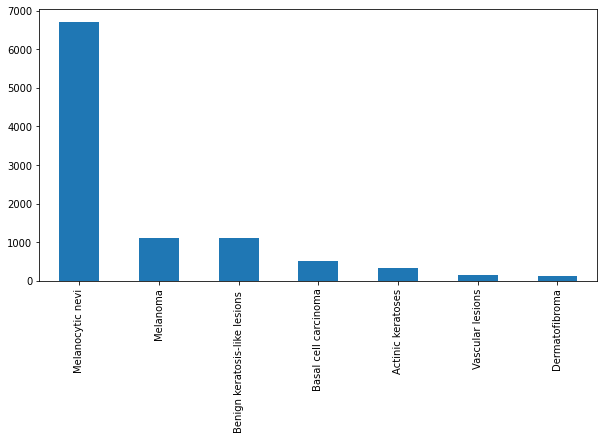

In [49]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
skin_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)
print(skin_df['cell_type'].value_counts())

**Its seems from the above plot that in this dataset cell type Melanecytic nevi has very large number of instances in comparison to other cell types**

<AxesSubplot:>

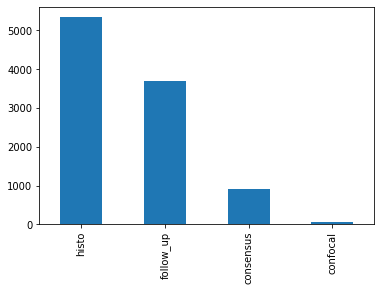

In [50]:
skin_df['dx_type'].value_counts().plot(kind='bar')

<AxesSubplot:>

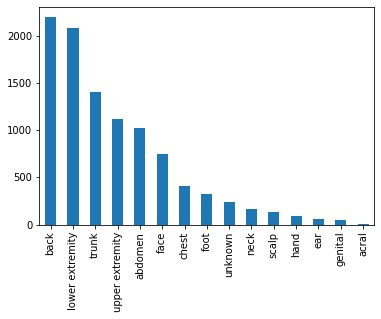

In [51]:
skin_df['localization'].value_counts().plot(kind='bar')

**It seems back , lower extremity,trunk and upper extremity are heavily compromised regions of skin cancer**

<AxesSubplot:>

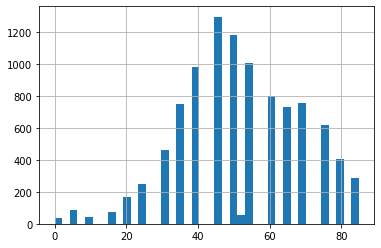

In [52]:
skin_df['age'].hist(bins=40)

It seems that there are larger instances of patients having age from 30 to 60

<AxesSubplot:>

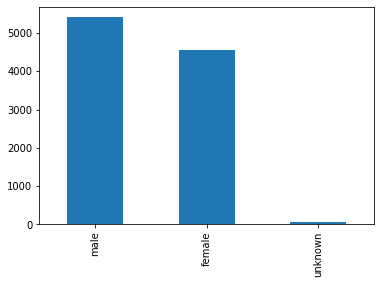

In [53]:
skin_df['sex'].value_counts().plot(kind='bar')

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='age', ylabel='cell_type_idx'>

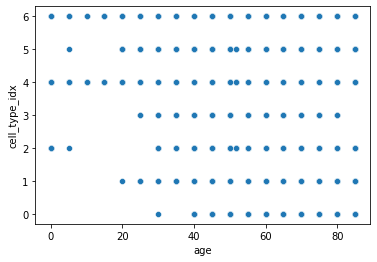

In [54]:
sns.scatterplot('age','cell_type_idx',data=skin_df)

**It seems that skin cancer types 0,1, 3 and 5 which are Melanocytic nevi,dermatofibroma,Basal cell carcinoma and Vascular lesions are not much prevalant below the age of 20 years**

In [55]:
# Lets know more about our dataset
skin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   lesion_id      10015 non-null  object 
 1   image_id       10015 non-null  object 
 2   dx             10015 non-null  object 
 3   dx_type        10015 non-null  object 
 4   age            10015 non-null  float64
 5   sex            10015 non-null  object 
 6   localization   10015 non-null  object 
 7   path           10015 non-null  object 
 8   cell_type      10015 non-null  object 
 9   cell_type_idx  10015 non-null  int8   
dtypes: float64(1), int8(1), object(8)
memory usage: 714.1+ KB


**Task 3**: Loading and Re-sizing of images

# **Pre-processing of the data**

In this step images will be loaded into the column named 'image' from the image path of the image folder. We also resized the images as the original dimension of images are 450 x 600 x 3 and was not being able to handled by TensorFlow, so that's why we resized it into 75 x 100. 
**As this step resize all the 10015 images dimensions into  75 x 100 so be patient it will take some time.**

In [14]:
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((75,100))))

In [15]:
# Let's check our full dataset again to gain knowledge of the changes that we introduced in it.
skin_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,./skin-mnist-images\HAM10000_images_part_1\ISI...,Benign keratosis-like lesions,2,"[[[191, 154, 196], [191, 155, 197], [191, 149,..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,./skin-mnist-images\HAM10000_images_part_1\ISI...,Benign keratosis-like lesions,2,"[[[24, 13, 22], [24, 14, 25], [29, 17, 35], [4..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,./skin-mnist-images\HAM10000_images_part_1\ISI...,Benign keratosis-like lesions,2,"[[[187, 129, 139], [192, 135, 150], [197, 143,..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,./skin-mnist-images\HAM10000_images_part_1\ISI...,Benign keratosis-like lesions,2,"[[[23, 11, 18], [30, 15, 25], [50, 29, 39], [7..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,./skin-mnist-images\HAM10000_images_part_2\ISI...,Benign keratosis-like lesions,2,"[[[135, 91, 114], [152, 107, 131], [169, 125, ..."


**Let's visualize the sample images of each class**

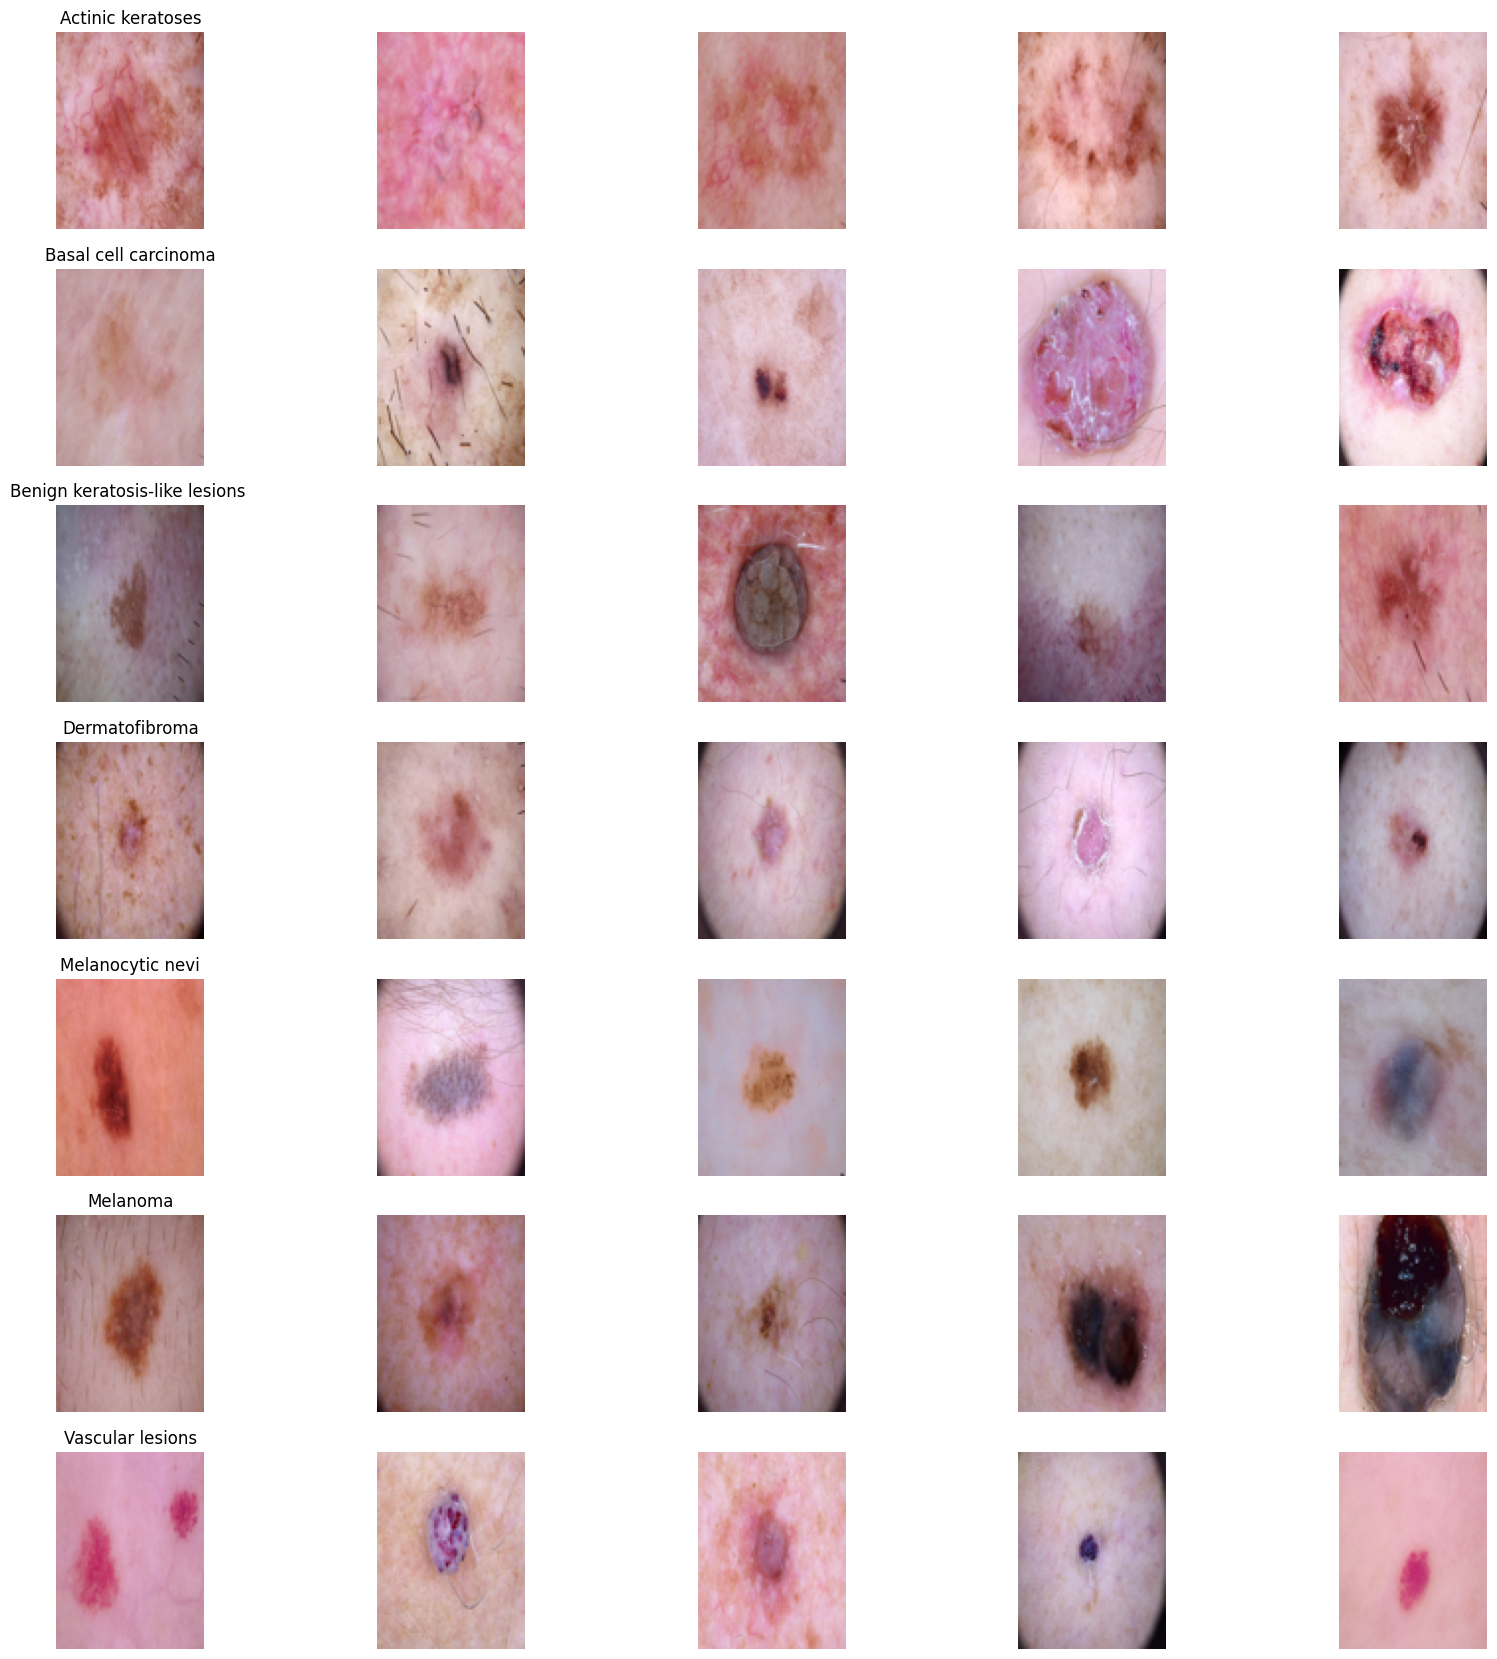

In [16]:
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

In [17]:
# Dividing our independent and dependant features 
features=skin_df.drop(columns=['cell_type_idx'],axis=1)
target=skin_df['cell_type_idx']


**Task 4: Train-Test data Splitting**


In [18]:
# In this step we have split the dataset into training and testing set of 80:20 ratio
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.25,random_state=1234)

**Task 5** : Normalization


Data normalization is an important step which ensures that each input parameter (pixel, in this case) has a similar data distribution. This makes convergence faster while training the network. Data normalization is done by subtracting the mean from each pixel and then dividing the result by the standard deviation. The distribution of such data would resemble a Gaussian curve centered at zero. For image inputs we need the pixel numbers to be positive, so we might choose to scale the normalized data in the range [0,1] or [0, 255].

In [19]:
# Normalizing the x_train, x_test by substracting them from their mean values and then dividing by their standard deviation.
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

**Task 6**: Label Encoding

Labels are 7 different classes of skin cancer types from 0 to 6. We need to encode these lables to one hot vectors

In [20]:
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

**Task 7**: Splitting the data into training and validation 


In [21]:
# I choosed to split the train set in two parts : a small fraction (10%) became the validation set which the model is evaluated and the rest (90%) is used to train the model
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)

In [22]:
import tensorflow as tf

In [23]:
input_shape = x_validate[0,:,:,:].shape
model_input = tf.keras.Input(shape=input_shape)

In [24]:
# Reshape image in 3 dimensions (height = 75px, width = 100px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

In [25]:
#Data Augmentation
dataaugment = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=90,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
        shear_range = 10) 

dataaugment.fit(x_train)

# **Model Applying - CNN**

**About CNN:**

The Convolutional Neural Network is a specialised type of neural network, ideal for data that can be represented as a grid. CNN is most commonly used for image recognition tasks since this input can be perceived as a 2D grid of pixels. CNN are neural networks that use at least one of their layers the convolution operation. For image classification tasks, Convolutional Neural Networks (CNN) are used most often.

The CNN architecture can vary and later we will explore well-known CNN models. In this section, it is presented a basic CNN architecture inspired by previous works and trial and error.

Average Pooling performed better than MaxPooling during my trials
Batch Normalization and Dropout seems to help avoid overfitting
A smaller pooling window (2,2) seems to perform better than larger kernel size (3,3) and (5,5)
Convolutional Layer > Activation Function > Batch Normalization > Dropout was the best combination I found
I understand that the original paper on Batch Normalization indicated the use of Batch before Activation, and I have tried such combination that reduced the accuracy by about 2%

Similar to how a child learns to recognise objects, we need to show an algorithm millions of pictures before it is be able to generalize the input and make predictions for images it has never seen before.

Computers ‘see’ in a different way than we do. Their world consists of only numbers. Every image can be represented as 2-dimensional arrays of numbers, known as pixels.

Convolutional Neural Networks are a bit different. First of all, the layers are organised in 3 dimensions: width, height and depth. Further, the neurons in one layer do not connect to all the neurons in the next layer but only to a small region of it. Lastly, the final output will be reduced to a single vector of probability scores, organized along the depth dimension.

In [27]:
#Model Parameters
input_shape = (75, 100, 3)
num_classes = 7

optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

epochs = 100   # formulae for epochs -> input size//batch size
batch_size = 32       # taking in power of 2

from keras.callbacks import EarlyStopping
#Callbacks
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=5, verbose=0, factor=0.5, min_lr=0.00001)
early_stopping_monitor = EarlyStopping(patience=20,monitor='val_accuracy')

c:\Users\Soha\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\optimizers\base_optimizer.py:34: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [28]:
def hist(model):
    model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])
    history = model.fit(dataaugment.flow(x_train,y_train, batch_size=batch_size),
                        epochs = epochs, validation_data = (x_validate,y_validate),
                        verbose = 2, steps_per_epoch=x_train.shape[0] // batch_size, 
                        callbacks=[learning_rate_reduction,early_stopping_monitor])

    loss, accuracy = model.evaluate(x_test, y_test, verbose=2)
    predictions = model.predict(x_test)
    loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=2)
    loss_t, accuracy_t = model.evaluate(x_train, y_train, verbose=2)
    return (predictions,accuracy_t,accuracy_v,accuracy)

In [29]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
import keras.backend as K
import math
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(BatchNormalization())
##############################
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
##############################
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(BatchNormalization())
model.add(AveragePooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
##############################
model.add(Flatten())

model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Activation('relu'))
model.add(Dropout(0.25))

#Output
model.add(BatchNormalization())
model.add(Dense(num_classes, activation='softmax'))

model.summary()

c:\Users\Soha\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 75, 100, 32)    │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 75, 100, 32)    │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 100, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 100, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 37, 50, 64)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 37, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 50, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 37, 50, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 37, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 18, 25, 64)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 18, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 18, 25, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 18, 25, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_2             │ (None, 9, 12, 64)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 9, 12, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 9, 12, 64)      │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 9, 12, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 9, 12, 64)      │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 9, 12, 64)      │           256 │
│ (BatchNormalization)            │                        │             

 Total params: 409,991 (1.56 MB)

 Trainable params: 405,831 (1.55 MB)

 Non-trainable params: 4,160 (16.25 KB)

In [31]:
from tensorflow.keras.optimizers import Adam, SGD
# Define the optimizer
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

# Compile the model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
# Set a learning rate annealer
# applying callbacks
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
early_stopping_monitor = EarlyStopping(patience=20,monitor='val_accuracy')

c:\Users\Soha\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\optimizers\base_optimizer.py:34: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [32]:
history = model.fit(dataaugment.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate))

Epoch 1/100


ValueError: None values not supported.

In [73]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=0)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

Validation: accuracy = 0.752660  ;  loss_v = 0.734620
Test: accuracy = 0.730831  ;  loss = 0.749900


Text(0.5, 1.0, 'Training and validation loss')

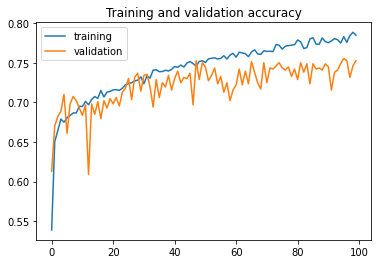

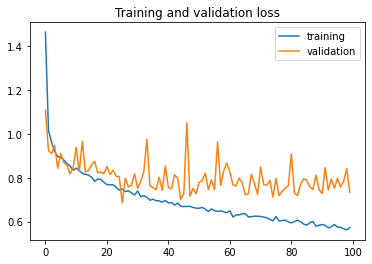

In [74]:
# Retrieve a list of accuracy results on training and test data
# sets for each training epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Retrieve a list of list results on training and test data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc, label = "training")
plt.plot(epochs, val_acc, label = "validation")
plt.legend(loc="upper left")
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss, label = "training")
plt.plot(epochs, val_loss, label = "validation")
plt.legend(loc="upper right")
plt.title('Training and validation loss')

We will be plotting Confusion Matrix for the above CNN model.

**A confusion matrix, also known as an error matrix, is a summarized table used to assess the performance of a classification model. The number of correct and incorrect predictions are summarized with count values and broken down by each class.**

1. Accuracy:
   This is simply equal to the proportion of predictions that the model classified correctly.
2. Precision:
   It is the proportion of positive identifications that are actually correct.
3. Recall:
   It is the proportion of actual positives that are identified correctly.
4. F1 Score:
   it is a measure of the preciseness of your model and is the harmonic mean of precision and recall. It ranges between 0-1.


In [75]:
# Function to plot confusion matrix    

def plot_confusion_matrix(cm,classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
#The number of correct and incorrect predictions are summarized with count values and broken down by each class in a confusion matrix
    plt.imshow(cm, interpolation='nearest', cmap=cmap) 
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes)) 
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] 
        
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Classification report for classifier <tensorflow.python.keras.engine.sequential.Sequential object at 0x7feaf1efc610>:
              precision    recall  f1-score   support

     class 0       0.59      0.31      0.41        32
     class 1       0.79      0.31      0.45        35
     class 2       0.53      0.39      0.45        79
     class 3       0.50      0.20      0.29        10
     class 4       0.83      0.93      0.87       507
     class 5       0.42      0.44      0.43        78
     class 6       0.90      0.82      0.86        11

    accuracy                           0.75       752
   macro avg       0.65      0.49      0.54       752
weighted avg       0.74      0.75      0.73       752




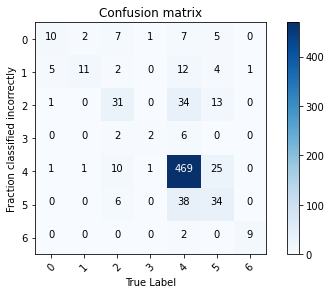

In [76]:
from sklearn import metrics
# Predict the values from the validation dataset
Y_pred = model.predict(x_validate)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_validate,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')

#Show Classification report
target_names = ['class 0', 'class 1', 'class 2','class 3', 'class 4', 
                'class 5', 'class 6']
print("Classification report for classifier %s:\n%s\n"
      % (model, metrics.classification_report(Y_true, Y_pred_classes, target_names = target_names)))

# **Transfer learning Models :**

**1. InceptionV3 model**

In [77]:
from tensorflow.compat.v1.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers

input_shape = (75, 100, 3)

num_labels = 7

base_model = InceptionV3(include_top = False, input_shape = input_shape,pooling = 'avg', 
                         weights = 'imagenet')
model = Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Dense(128, activation="relu",kernel_regularizer=regularizers.l2(0.02)))
model.add(Dropout(0.5))
model.add(Dense(num_labels, activation = 'softmax',kernel_regularizer=regularizers.l2(0.02)))

for layer in base_model.layers:
    layer.trainable = True

model.summary()

87916544/87910968 [==============================] - 1s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
dropout_10 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               262272    
_________________________________________________________________
dropout_11 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 7)                 903       
Total params: 22,065,959
Trainable params: 22,031,527
Non-trainable params: 34,432
_________________________________________________________________


In [78]:
optimizer = Adam (lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=5e-7, amsgrad=False)
model.compile(optimizer = optimizer , loss = "sparse_categorical_crossentropy", metrics=["accuracy"])

In [79]:
y_train = np.argmax(y_train, axis = 1)
y_validate = np.argmax(y_validate, axis = 1)

In [80]:
epochs = 35
batch_size = 20
history = model.fit(dataaugment.flow(x_train, y_train, batch_size = batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)

Epoch 1/35
337/337 [==============================] - 26s 58ms/step - loss: 4.2833 - accuracy: 0.6517 - val_loss: 3.4668 - val_accuracy: 0.6742
Epoch 2/35
337/337 [==============================] - 17s 52ms/step - loss: 1.5613 - accuracy: 0.6693 - val_loss: 1.1626 - val_accuracy: 0.6848
Epoch 3/35
337/337 [==============================] - 17s 51ms/step - loss: 1.2014 - accuracy: 0.6773 - val_loss: 5.0973 - val_accuracy: 0.6795
Epoch 4/35
337/337 [==============================] - 17s 51ms/step - loss: 1.1040 - accuracy: 0.6724 - val_loss: 3.9426 - val_accuracy: 0.6742
Epoch 5/35
337/337 [==============================] - 17s 51ms/step - loss: 1.0694 - accuracy: 0.6697 - val_loss: 1.0241 - val_accuracy: 0.6782
Epoch 6/35
337/337 [==============================] - 17s 52ms/step - loss: 1.0382 - accuracy: 0.6769 - val_loss: 1.1357 - val_accuracy: 0.6902
Epoch 7/35
337/337 [==============================] - 17s 51ms/step - loss: 1.0173 - accuracy: 0.6781 - val_loss: 1.2299 - val_accuracy:

In [81]:
y_test = np.argmax(y_test, axis = 1)

In [82]:
loss, Inception_accuracy = model.evaluate(x_test, y_test, verbose=0)
loss_v, Inception_accuracy_v = model.evaluate(x_validate, y_validate, verbose=0)
print("Validation: accuracy = %f  ;  loss_v = %f" % (Inception_accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % ( Inception_accuracy, loss))

Validation: accuracy = 0.710106  ;  loss_v = 0.855754
Test: accuracy = 0.709665  ;  loss = 0.843685


**2. XCeption:**

Xception is a convolutional neural network that is 71 layers deep. You can load a pretrained version of the network trained on more than a million images from the ImageNet database.

According to the author of XCeption paper, Francois Chollet, this architecture relies on the lessons learned with VGG-16 and previous Inception models. Also, they use residual connections (a concept introduced in ResNet) and depthwise separable convolutions inspired by the initial work of Vanhoucke (2014). In total, XCeption uses 39 Convolutional Layers.

In [83]:
from tensorflow.keras.applications.xception import Xception

input_shape = (75, 100, 3)

num_labels = 7

base_model = Xception(include_top = False, input_shape = input_shape,pooling = 'avg', 
                         weights = 'imagenet')
model = Sequential()
model.add(base_model)
model.add(Dropout(0.5))
model.add(Dense(128, activation="relu",kernel_regularizer=regularizers.l2(0.02)))
model.add(Dropout(0.5))
model.add(Dense(num_labels, activation = 'softmax',kernel_regularizer=regularizers.l2(0.02)))

for layer in base_model.layers:
    layer.trainable = True

model.summary()

83689472/83683744 [==============================] - 1s 0us/step
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 2048)              20861480  
_________________________________________________________________
dropout_12 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               262272    
_________________________________________________________________
dropout_13 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 7)                 903       
Total params: 21,124,655
Trainable params: 21,070,127
Non-trainable params: 54,528
_________________________________________________________________


In [84]:
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

In [85]:
#Traing and testing sampling
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20)
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

# Perform one-hot encoding on the labels
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

#Splitting training into Train and Validate sets
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1)

# Reshape image in 3 dimensions (height = 75px, width = 100px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

In [86]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])

In [87]:
epochs =  35
batch_size = 20
history = model.fit(dataaugment.flow(x_train, y_train, batch_size = batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size,
                    validation_steps=(x_validate.shape[0] // batch_size),
                    callbacks=[learning_rate_reduction])

Epoch 1/35
360/360 [==============================] - 26s 61ms/step - loss: 5.6630 - acc: 0.5934 - val_loss: 3.6337 - val_acc: 0.6646
Epoch 2/35
360/360 [==============================] - 20s 57ms/step - loss: 3.1174 - acc: 0.6630
Epoch 3/35
360/360 [==============================] - 20s 55ms/step - loss: 1.9512 - acc: 0.6924
Epoch 4/35
360/360 [==============================] - 20s 56ms/step - loss: 1.4090 - acc: 0.7058
Epoch 5/35
360/360 [==============================] - 20s 57ms/step - loss: 1.1061 - acc: 0.7340
Epoch 6/35
360/360 [==============================] - 20s 56ms/step - loss: 0.9720 - acc: 0.7397
Epoch 7/35
360/360 [==============================] - 20s 56ms/step - loss: 0.8890 - acc: 0.7458
Epoch 8/35
360/360 [==============================] - 20s 55ms/step - loss: 0.8339 - acc: 0.7553
Epoch 9/35
360/360 [==============================] - 20s 56ms/step - loss: 0.8022 - acc: 0.7556
Epoch 10/35
360/360 [==============================] - 20s 56ms/step - loss: 0.7655 - acc:

In [88]:
loss, XCeption_accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, XCeption_accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (XCeption_accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (XCeption_accuracy, loss))

26/26 [==============================] - 1s 21ms/step - loss: 0.9519 - acc: 0.7643
Validation: accuracy = 0.764339  ;  loss_v = 0.951933
Test: accuracy = 0.774838  ;  loss = 0.865555


In [89]:
# Function to plot confusion matrix    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier <tensorflow.python.keras.engine.sequential.Sequential object at 0x7fea4c4b6a10>:
              precision    recall  f1-score   support

     class 0       0.41      0.39      0.40        23
     class 1       0.52      0.50      0.51        44
     class 2       0.60      0.37      0.46        84
     class 3       0.00      0.00      0.00        11
     class 4       0.84      0.95      0.89       533
     class 5       0.54      0.37      0.44        99
     class 6       0.50      0.75      0.60         8

    accuracy                           0.76       802
   macro avg       0.49      0.48      0.47       802
weighted avg       0.73      0.76      0.74       802




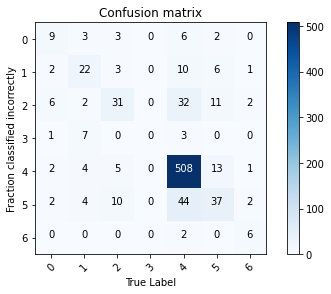

In [90]:
from sklearn import metrics
# Predict the values from the validation dataset
Y_pred = model.predict(x_validate)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_validate,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')

#Show Classification report
target_names = ['class 0', 'class 1', 'class 2','class 3', 'class 4', 
                'class 5', 'class 6']
print("Classification report for classifier %s:\n%s\n"
      % (model, metrics.classification_report(Y_true, Y_pred_classes, target_names = target_names)))


**3. ResNet:**

The idea behind the residual networks (ResNet) is an attempt to overcome a problem faced by many researchers when working with deeper models where the training error starts to increase as more layers are added to the network. One hypothesis is that accuracy degradation occurs in deeper models because they are harder to optimize.

From a quick literature review, it was noticed that ResNet was always among the pre-trained architectures used on the ISIC 2018 challenge. Here we use the ResNet-50, which uses 50 convolutional layers.

Best performance was achieved by training all layers of the ResNet50 and using the Imagenet dataset initial weights.

In [91]:
from tensorflow.keras.applications import ResNet50
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Softmax, Dropout
base_model = ResNet50(input_shape=(75, 100,3), include_top=False, weights="imagenet");
num_classes = 7
ResNet50model = Sequential()
ResNet50model.add(base_model)
ResNet50model.add(Dropout(0.2))
ResNet50model.add(Dense(128, activation="relu"))
ResNet50model.add(Dropout(0.2))
ResNet50model.add(Dense(num_classes, activation = 'softmax'))
###################################

for layer in base_model.layers:
    layer.trainable = True


94773248/94765736 [==============================] - 1s 0us/step


In [92]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Softmax, Dropout
base_model = tf.keras.applications.ResNet50(include_top=False, input_shape=(75,100, 3),pooling = 'avg', weights = 'imagenet');
num_classes = 7
ResNet50model = Sequential()
ResNet50model.add(base_model)
ResNet50model.add(Dropout(0.2))
ResNet50model.add(Dense(128, activation="relu"))
ResNet50model.add(Dropout(0.2))
ResNet50model.add(Dense(num_classes, activation = 'softmax'))
###################################

for layer in base_model.layers:
    layer.trainable = True

ResNet50model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dropout_16 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               262272    
_________________________________________________________________
dropout_17 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 7)                 903       
Total params: 23,850,887
Trainable params: 23,797,767
Non-trainable params: 53,120
_________________________________________________________________


In [93]:
ResNet50y_pred,ResNet50accuracy_t,ResNet50accuracy_v,ResNet_accuracy = hist(ResNet50model) 
    
print("ResNet50 Training: accuracy = %f" % (ResNet50accuracy_t))
print("ResNet50 Validation: accuracy = %f" % (ResNet50accuracy_v))
print("ResNet50 Test: accuracy = %f" % (ResNet_accuracy))

Epoch 1/35
360/360 - 26s - loss: 1.0156 - accuracy: 0.6716 - val_loss: 16.4116 - val_accuracy: 0.6646
Epoch 2/35
360/360 - 19s - loss: 0.8082 - accuracy: 0.6994 - val_loss: 1.1386 - val_accuracy: 0.6646
Epoch 3/35
360/360 - 17s - loss: 0.7505 - accuracy: 0.7223 - val_loss: 0.7903 - val_accuracy: 0.7232
Epoch 4/35
360/360 - 18s - loss: 0.7248 - accuracy: 0.7323 - val_loss: 0.7554 - val_accuracy: 0.7257
Epoch 5/35
360/360 - 17s - loss: 0.7050 - accuracy: 0.7374 - val_loss: 0.7177 - val_accuracy: 0.7382
Epoch 6/35
360/360 - 18s - loss: 0.6818 - accuracy: 0.7442 - val_loss: 0.7127 - val_accuracy: 0.7469
Epoch 7/35
360/360 - 17s - loss: 0.6709 - accuracy: 0.7491 - val_loss: 0.7959 - val_accuracy: 0.7506
Epoch 8/35
360/360 - 17s - loss: 0.6552 - accuracy: 0.7561 - val_loss: 0.7085 - val_accuracy: 0.7556
Epoch 9/35
360/360 - 18s - loss: 0.6260 - accuracy: 0.7647 - val_loss: 0.7129 - val_accuracy: 0.7431
Epoch 10/35
360/360 - 18s - loss: 0.6330 - accuracy: 0.7638 - val_loss: 0.6998 - val_accur

Classification report for classifier <tensorflow.python.keras.engine.sequential.Sequential object at 0x7fea4c4b6a10>:
              precision    recall  f1-score   support

     class 0       0.52      0.48      0.50        23
     class 1       0.54      0.43      0.48        44
     class 2       0.61      0.36      0.45        84
     class 3       0.25      0.09      0.13        11
     class 4       0.83      0.94      0.88       533
     class 5       0.54      0.42      0.47        99
     class 6       0.55      0.75      0.63         8

    accuracy                           0.76       802
   macro avg       0.55      0.50      0.51       802
weighted avg       0.74      0.76      0.74       802




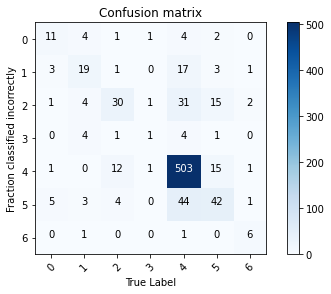

In [94]:
from sklearn import metrics
# Predict the values from the validation dataset
Y_pred = ResNet50model.predict(x_validate)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_validate,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')

#Show Classification report
target_names = ['class 0', 'class 1', 'class 2','class 3', 'class 4', 
                'class 5', 'class 6']
print("Classification report for classifier %s:\n%s\n"
      % (model, metrics.classification_report(Y_true, Y_pred_classes, target_names = target_names)))

## **SUMMARY OF ALL MODELS WITH RESPECT TO THEIR ACCURACY:-**

In [95]:
print("CNN MODEL = %f" % (accuracy))
print("InceptionV3 MODEL = %f" % (Inception_accuracy))
print("XCeption MODEL = %f" % (XCeption_accuracy))
print("ResNet50 MODEL = %f" % (ResNet_accuracy))


CNN MODEL = 0.730831
InceptionV3 MODEL = 0.709665
XCeption MODEL = 0.774838
ResNet50 MODEL = 0.775337


In [97]:
model.save('ResNet50_model.h5')